In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=5000) # just read first 5000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(73641, 4)

In [8]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [9]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim = 32
final_dim = 16
latent_dim = 4
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim, activation='relu')(x)
h2 = Dense(final_dim, activation='relu')(h1)
z_mean = Dense(latent_dim)(h2)
z_log_sigma = Dense(latent_dim)(h2)

In [14]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [15]:
# decoder
decoder_h2 = Dense(final_dim, activation='relu')
decoder_h1 = Dense(inter_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h2_decoded = decoder_h2(z)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [16]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [17]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [18]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            68          dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
batch_size = 200
epochs = 100

In [21]:
x_train.shape

(58912, 4)

In [22]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val))

Train on 58912 samples, validate on 7364 samples
Epoch 1/100
58912/58912 [==============================] - 2s 38us/step - loss: 0.9229 - val_loss: 0.7430
Epoch 2/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.7035 - val_loss: 0.6672
Epoch 3/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6595 - val_loss: 0.6523
Epoch 4/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6447 - val_loss: 0.6384
Epoch 5/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6400 - val_loss: 0.6360
Epoch 6/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6361 - val_loss: 0.6318
Epoch 7/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6293 - val_loss: 0.6256
Epoch 8/100
58912/58912 [==============================] - 2s 27us/step - loss: 0.6305 - val_loss: 0.6264
Epoch 9/100
58912/58912 [==============================] - 2s 26us/step - loss: 0.6277 - val_loss: 0.62

58912/58912 [==============================] - 1s 24us/step - loss: 0.6041 - val_loss: 0.6040
Epoch 78/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6037 - val_loss: 0.5985
Epoch 79/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6035 - val_loss: 0.5971
Epoch 80/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6050 - val_loss: 0.6018
Epoch 81/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6024 - val_loss: 0.5985
Epoch 82/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6025 - val_loss: 0.6093
Epoch 83/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6040 - val_loss: 0.5994
Epoch 84/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6032 - val_loss: 0.6015
Epoch 85/100
58912/58912 [==============================] - 1s 24us/step - loss: 0.6062 - val_loss: 0.6025
Epoch 86/100
58912/58912 [========================

# Visualization

In [23]:
import matplotlib.pyplot as plt

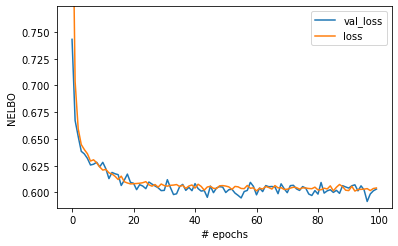

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [25]:
predictions = vae.predict(x_test)

In [26]:
predictions

array([[-0.31860852, -0.2217254 , -0.8620342 , -0.2610172 ],
       [-0.3502915 ,  1.0951138 , -0.41847637, -0.2845958 ],
       [-0.41989505,  1.2177718 ,  0.7398839 , -0.30688342],
       ...,
       [-0.3566109 , -0.6563587 , -0.21193004, -0.2824178 ],
       [-0.39668548, -0.9366727 , -0.49533254, -0.3143061 ],
       [-0.3707764 , -0.62992084,  0.7199376 , -0.28598222]],
      dtype=float32)

In [27]:
distr = (x_test - predictions) / x_test

In [28]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [29]:
pT = [row[0] for row in x_test]
eta = [row[1] for row in x_test]
phi = [row[2] for row in x_test]
mass = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

(array([0., 2., 1., 3., 2., 3., 6., 3., 2., 2., 0., 6., 3., 4., 5., 2., 3.,
        2., 0., 1., 2., 3., 2., 3., 3., 5., 3., 5., 0., 2., 1., 6., 1., 3.,
        1., 3., 3., 3., 3.]),
 array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
        0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
        0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
        0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
        0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
        0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
        0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
        0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ]),
 <a list of 39 Patch objects>)

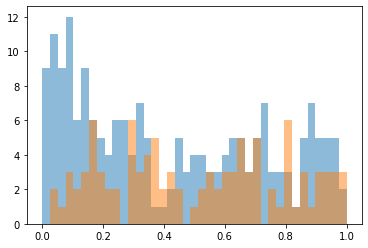

In [58]:
bins = np.linspace(0, 1, 40)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)

(array([ 65.,  62.,  56.,  45.,  63.,  62.,  62.,  59.,  67.,  88.,  73.,
         62.,  58.,  65.,  64.,  66.,  53.,  78.,  53.,  53.,  41.,  49.,
         53.,  56.,  50.,  51.,  39.,  50.,  37.,  61.,  53.,  51.,  55.,
         60.,  49.,  70.,  71., 132., 250., 309., 244., 146.,  87.,  74.,
         60.,  49.,  58.,  57.,  55.,  50.,  58.,  48.,  59.,  62.,  42.,
         64.,  61.,  61.,  48.,  54.,  58.,  54.,  60.,  63.,  60.,  43.,
         57.,  61.,  65.,  57.,  57.,  62.,  64.,  45.,  60.,  68.,  75.,
         78.,  61.]),
 array([-1.        , -0.97468354, -0.94936709, -0.92405063, -0.89873418,
        -0.87341772, -0.84810127, -0.82278481, -0.79746835, -0.7721519 ,
        -0.74683544, -0.72151899, -0.69620253, -0.67088608, -0.64556962,
        -0.62025316, -0.59493671, -0.56962025, -0.5443038 , -0.51898734,
        -0.49367089, -0.46835443, -0.44303797, -0.41772152, -0.39240506,
        -0.36708861, -0.34177215, -0.3164557 , -0.29113924, -0.26582278,
        -0.24050633, -

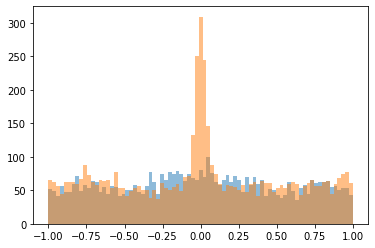

In [59]:
bins = np.linspace(-1, 1, 80)
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([121., 116.,  98.,  93., 100.,  85., 102.,  74.,  85.,  93.,  85.,
         90.,  81.,  74.,  86.,  77.,  80.,  68.,  88.,  62.,  53.,  73.,
         70.,  63.,  64.,  74.,  69.,  63.,  60.,  60.,  56.,  69.,  51.,
         67.,  57.,  67.,  83.,  55.,  56.,  58.,  56.,  58.,  57.,  80.,
         68.,  67.,  62.,  61.,  61.,  70.,  59.,  59.,  57.,  71.,  61.,
         66.,  66.,  75.,  58.,  65.,  64.,  56.,  55.,  62.,  48.,  65.,
         80.,  96., 131., 103., 100., 114., 103.,  92.,  78.,  79.,  89.,
         90.,  83.]),
 array([-1.        , -0.97468354, -0.94936709, -0.92405063, -0.89873418,
        -0.87341772, -0.84810127, -0.82278481, -0.79746835, -0.7721519 ,
        -0.74683544, -0.72151899, -0.69620253, -0.67088608, -0.64556962,
        -0.62025316, -0.59493671, -0.56962025, -0.5443038 , -0.51898734,
        -0.49367089, -0.46835443, -0.44303797, -0.41772152, -0.39240506,
        -0.36708861, -0.34177215, -0.3164557 , -0.29113924, -0.26582278,
        -0.24050633, -

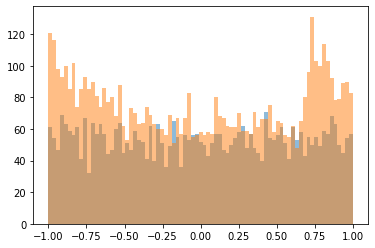

In [60]:
bins = np.linspace(-1, 1, 80)
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([2.000e+00, 1.400e+01, 2.730e+02, 1.576e+03, 3.203e+03, 7.500e+02,
        1.840e+02, 7.300e+01, 4.900e+01, 2.800e+01, 2.200e+01, 1.600e+01,
        5.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 1.200e+01, 7.000e+00,
        1.100e+01, 6.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 9.000e+00,
        9.000e+00, 8.000e+00, 1.100e+01, 5.000e+00, 1.100e+01, 7.000e+00,
        7.000e+00, 8.000e+00, 9.000e+00, 6.000e+00, 1.000e+01, 1.000e+01,
        1.000e+01, 9.000e+00, 1.000e+01, 1.300e+01, 2.000e+01, 2.200e+01,
        3.200e+01, 1.600e+01, 2.600e+01, 2.000e+01, 2.300e+01, 2.100e+01,
        1.800e+01, 2.000e+01, 2.300e+01, 2.100e+01, 2.000e+01, 1.400e+01,
        6.000e+00, 8.000e+00, 9.000e+00, 9.000e+00, 1.100e+01]),
 array([-0.4       , -0.37627119, -0.35254237, -0.32881356, -0.30508475,
        -0.28135593, -0.25762712, -0.23389831, -0.21016949, -0.18644068,
        -0.16271186, -0.13898305, -0.11525424, -0.09152542, -0.06779661,
        -0.0440678 , -0.02033898,  0.00338983,  0.

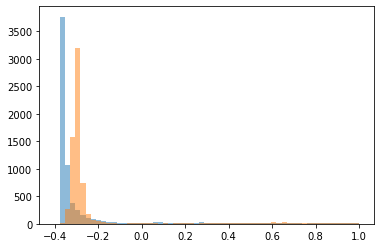

In [67]:
bins = np.linspace(-.4,1, 60)
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [52]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [53]:
bins = np.linspace(-1, 1, 30)

(array([  11.,   20.,   16.,   15.,   10.,   17.,   19.,   24.,   33.,
          44.,   52.,   93.,  151.,  323.,  992., 2444., 1650.,  452.,
         236.,  130.,   69.,   40.,   22.,   22.,   16.,   11.,    8.,
           8.,    7.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

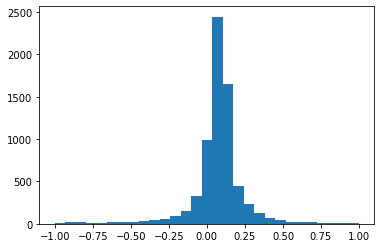

In [54]:
plt.hist(d_pT, bins=bins)

(array([ 30.,  36.,  40.,  41.,  50.,  53.,  79.,  54.,  71., 101., 131.,
        117., 127., 151., 202., 232., 234., 359., 405., 423., 319., 294.,
        280., 202., 205., 185., 192., 222., 242.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

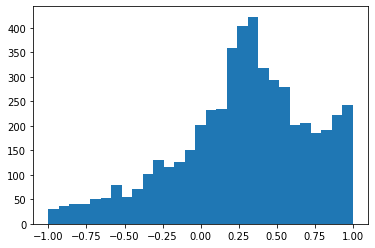

In [55]:
plt.hist(d_eta, bins=bins)

(array([ 27.,  38.,  44.,  54.,  53.,  56.,  67.,  62.,  68.,  73., 104.,
        123., 165., 149., 217., 238., 293., 384., 495., 450., 401., 361.,
        266., 214., 233., 170., 149., 154., 110.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

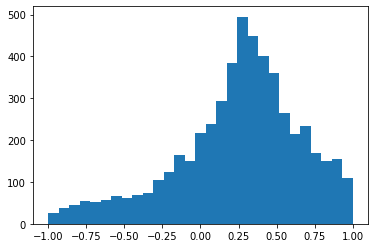

In [56]:
plt.hist(d_phi, bins=bins)